Epoch [1/100], Train Loss: 7.74120, Val Loss: 3.89506
=> Saving checkpoint
Epoch [2/100], Train Loss: 4.36312, Val Loss: 2.70728
=> Saving checkpoint
Epoch [3/100], Train Loss: 3.64219, Val Loss: 2.14456
=> Saving checkpoint
Epoch [4/100], Train Loss: 3.29584, Val Loss: 2.14466
Epoch [5/100], Train Loss: 3.27726, Val Loss: 1.91649
=> Saving checkpoint
Epoch [6/100], Train Loss: 2.62772, Val Loss: 1.40540
=> Saving checkpoint
Epoch [7/100], Train Loss: 2.07739, Val Loss: 0.95585
=> Saving checkpoint
Epoch [8/100], Train Loss: 1.54970, Val Loss: 0.65255
=> Saving checkpoint
Epoch [9/100], Train Loss: 1.18188, Val Loss: 0.39470
=> Saving checkpoint
Epoch [10/100], Train Loss: 1.03478, Val Loss: 0.43092
Epoch [11/100], Train Loss: 0.87142, Val Loss: 0.30311
=> Saving checkpoint
Epoch [12/100], Train Loss: 1.17163, Val Loss: 0.92843
Epoch [13/100], Train Loss: 0.86425, Val Loss: 0.46534
Epoch [14/100], Train Loss: 0.61523, Val Loss: 0.24919
=> Saving checkpoint
Epoch [15/100], Train Loss: 0

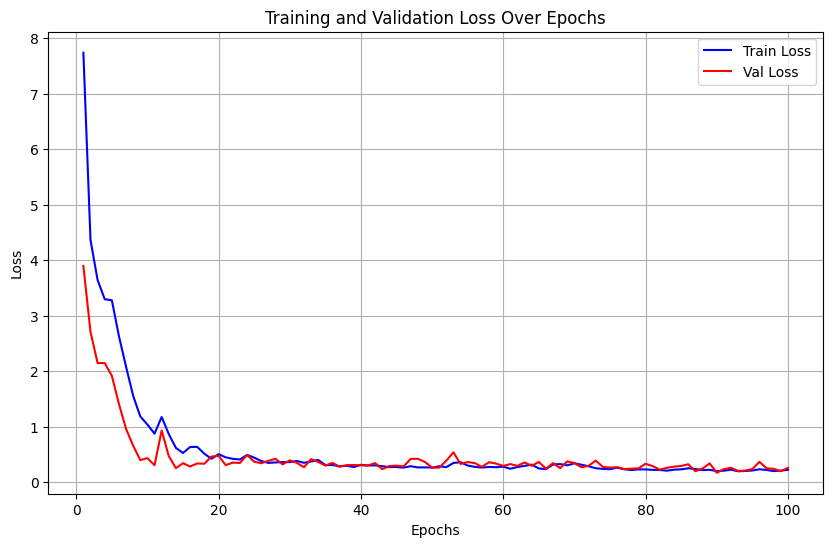

In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# Loading the data
proteomics_df = pd.read_csv('/content/drive/MyDrive/EMBL_Task/Skin/high_low_correlation_proteomics.csv')
transcriptomics_df  = pd.read_csv('/content/drive/MyDrive/EMBL_Task/Skin/high_low_correlation_transcriptomics.csv')

# Identify common genes and filter datasets
protein_names = set(proteomics_df.columns)
common_genes = [gene for gene in transcriptomics_df.columns if gene in protein_names]
filtered_transcriptomics_df = transcriptomics_df[common_genes]

# Find common columns between proteomics and transcriptomics
common_columns = sorted(list(set(proteomics_df.columns).intersection(set(transcriptomics_df.columns))))

filtered_proteomics_df = proteomics_df[common_columns]
filtered_transcriptomics_df = transcriptomics_df[common_columns]

# Split the data into train and validation sets
train_df_proteomics = filtered_proteomics_df.iloc[:40]
val_df_proteomics = filtered_proteomics_df.iloc[40:]
train_df_transcriptomics = filtered_transcriptomics_df.iloc[:40]
val_df_transcriptomics = filtered_transcriptomics_df.iloc[40:]

# Dataset class
class MultiOmicsDataset(Dataset):
    def __init__(self, proteomics_df, transcriptomics_df):
        self.subject_ids = proteomics_df["Unnamed: 0"].values
        self.proteomics_data = torch.tensor(proteomics_df.drop(columns=['Unnamed: 0']).values, dtype=torch.float32)
        self.transcriptomics_data = torch.tensor(transcriptomics_df.drop(columns=['Unnamed: 0']).values, dtype=torch.float32)

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        return {
            'subject_id': self.subject_ids[idx],
            'proteomics': self.proteomics_data[idx],
            'transcriptomics': self.transcriptomics_data[idx]
        }

# Create DataLoader
train_dataset = MultiOmicsDataset(train_df_proteomics, train_df_transcriptomics)
val_dataset = MultiOmicsDataset(val_df_proteomics, val_df_transcriptomics)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

class TranscriptToProteomicsTransformer(nn.Module):
    def __init__(self, feature_dim=32, d_model=128, nhead=2, num_layers=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.d_model = d_model

        # 1. Linear projection: embed each feature (token) into d_model
        self.input_proj = nn.Linear(1, d_model)

        # 2. Positional encoding: optional but helps capture position
        self.pos_embedding = nn.Parameter(torch.randn(1, feature_dim, d_model))

        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Project back to 1 value per feature
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: [B, feature_dim] → we treat each feature as a token
        Output: [B, feature_dim]
        """
        B, F = x.shape

        # Treat each feature as a token: reshape to [B, F, 1]
        x = x.unsqueeze(-1)

        # Project to transformer space: [B, F, d_model]
        x = self.input_proj(x)

        # Add position encoding
        x = x + self.pos_embedding[:, :F, :]

        # Transformer encoder
        x = self.transformer_encoder(x)  # [B, F, d_model]

        # Back to scalar predictions per feature
        x = self.output_proj(x).squeeze(-1)  # [B, F]
        return x
# Create the model
model = TranscriptToProteomicsTransformer()

# Define the optimizer and loss function
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training function
def train_fn(model, train_loader, optimizer):
    model.train()  # Set the model to training mode
    train_losses = []
    for batch in train_loader:
        x = batch['transcriptomics']
        y = batch['proteomics']
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(float(loss))
    return np.mean(train_losses)
# Validation function
def validate_fn(model, val_loader):
    model.eval()
    val_losses = []
    with torch.no_grad():  # No need to track gradients during validation
        for batch in val_loader:
            x = batch['transcriptomics']  # Input data
            y = batch['proteomics']       # Ground truth labels
            pred = model(x)               # Model predictions

            # Compute the loss
            loss = criterion(pred, y)
            val_losses.append(float(loss))  # Store the loss

    # Return the average validation loss
    return np.mean(val_losses)

# Training loop
Max_Epochs = 100


# Initialize lists to record losses
train_losses_record = []  # losses of all training epochs
val_losses_record = []    # losses of all validation epochs


path_to_save_check_points = '/content/drive/MyDrive/EMBL_Task/Skin/'
def save_checkpoint(state,name):
    print("=> Saving checkpoint")
    filename = path_to_save_check_points + name + ".pth.tar"
    torch.save(state, filename)

def main():
    min_val_loss = 10000
    for epoch in range(Max_Epochs):
        # Training
        train_loss = train_fn(model, train_loader, optimizer)
        train_losses_record.append(train_loss)

        # Validation
        val_loss = validate_fn(model, val_loader)
        val_losses_record.append(val_loss)

        # Print both train and validation loss for each epoch
        print(f"Epoch [{epoch+1}/{Max_Epochs}], Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

        if val_loss < min_val_loss:
             min_val_loss = val_loss
            # Save the checkpoint
             checkpoint = {
                  "state_dict": model.state_dict(),
                  }
             save_checkpoint(checkpoint,'High_Low_Correlation_Model')
    # After training is complete, plot the loss curves
    plot_losses()

def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Max_Epochs + 1), train_losses_record, label="Train Loss", color='blue')#, marker='o')
    plt.plot(range(1, Max_Epochs + 1), val_losses_record, label="Val Loss", color='red')#, marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


<ipython-input-8-48f986b0db66>:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_checkpoints,map_location=DEVICE)


tensor([[ 1.7885,  8.1072, -4.7667,  7.1688,  9.2352,  9.0308,  8.0594, -2.3437,
         10.9697,  9.4067,  4.8450, -5.8615,  0.6614,  6.1663,  6.9241,  8.4197,
          2.0327, -1.1890, -0.0734, -3.8031,  5.7770,  6.6969,  6.0864,  8.7233,
          9.8746,  8.3192,  7.2096,  8.8580,  5.8708,  9.2625, 11.2771,  3.6807]])
(32,) (32,)
Quanitative Results for : ['SIDM01105']
                         Metric    Value
Pearson Correlation Coefficient 0.990371
       Mean Squared Error (MSE) 0.101336
 Root Mean Squared Error (RMSE) 0.318333
      Mean Absolute Error (MAE) 0.255804
                 R-squared (R²) 0.979660


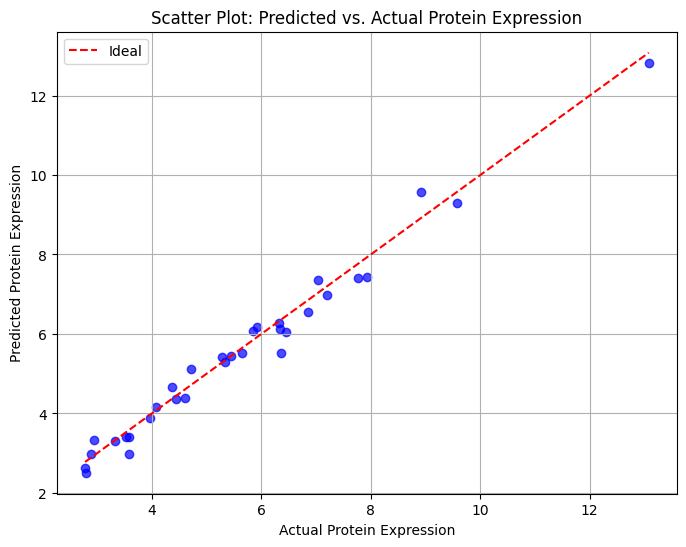

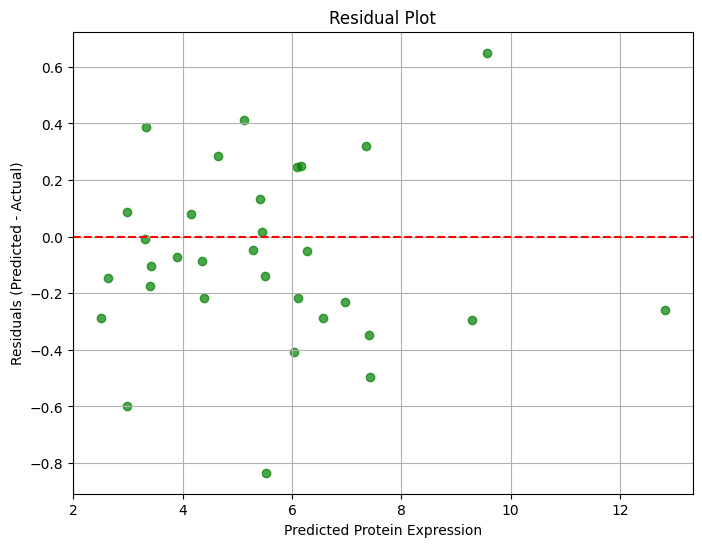

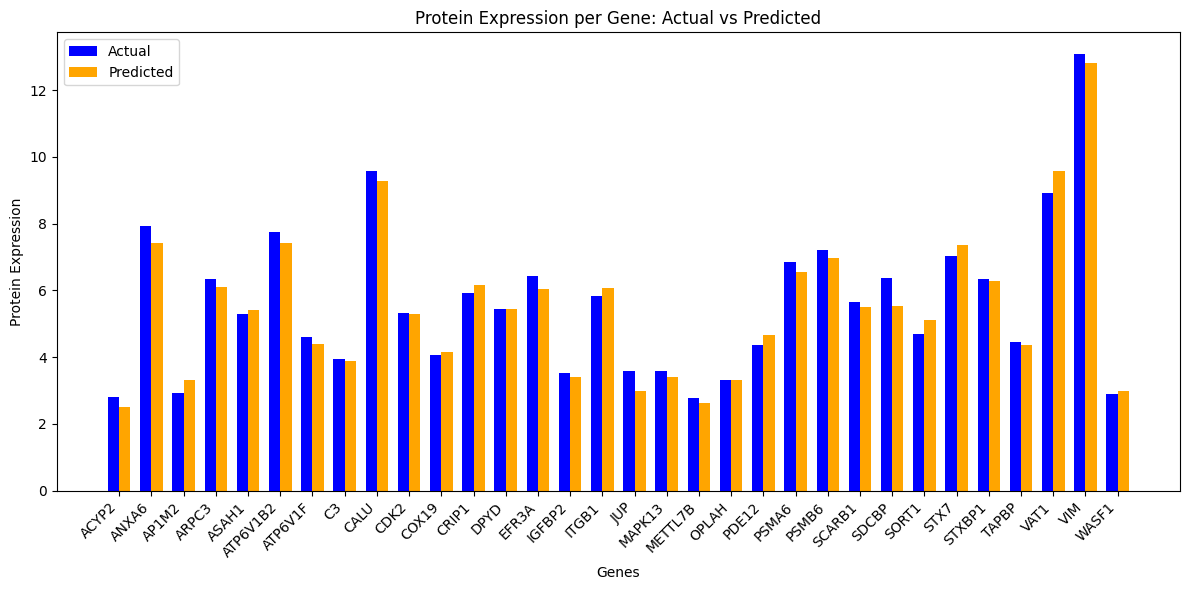

tensor([[ 1.8234,  7.5493, -2.6182,  7.3602,  8.9457,  8.3573,  7.7566, -1.5750,
          9.7992,  8.4664,  4.2217, -3.4225,  1.2482,  6.1523,  4.4775,  8.5869,
          4.3244,  1.4214,  0.3685, -0.2734,  5.7279,  6.7075,  5.8661,  8.2853,
          9.2719,  8.0493,  7.2458,  7.7955,  6.2933,  9.2210,  9.6206,  3.2951]])
(32,) (32,)
Quanitative Results for : ['SIDM01107']
                         Metric    Value
Pearson Correlation Coefficient 0.974277
       Mean Squared Error (MSE) 0.254944
 Root Mean Squared Error (RMSE) 0.504920
      Mean Absolute Error (MAE) 0.380504
                 R-squared (R²) 0.947546


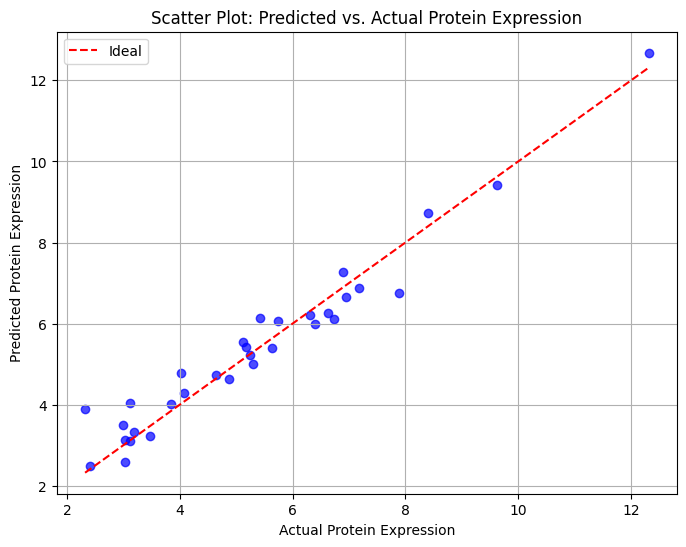

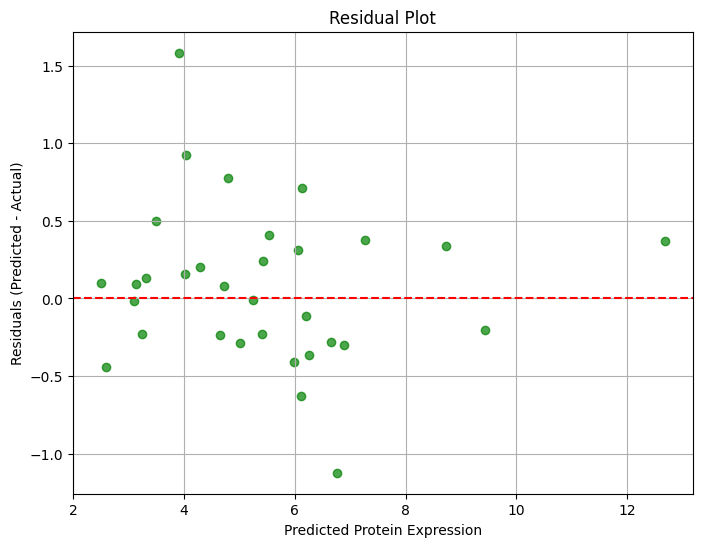

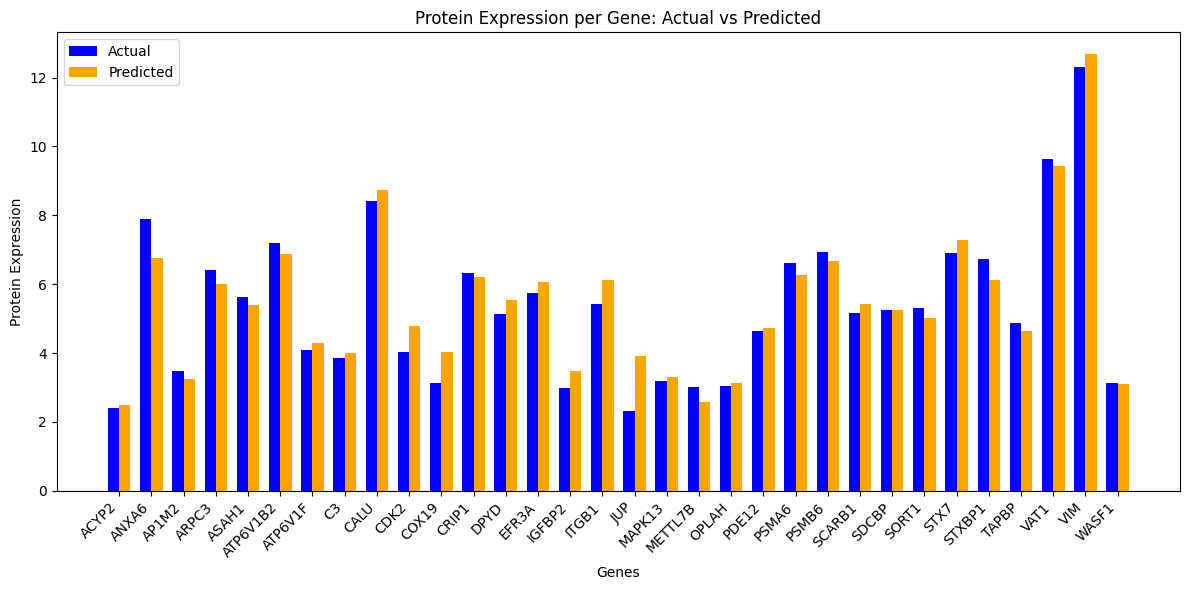

tensor([[ 2.1369,  5.8665,  0.3313,  7.4967,  7.1966,  7.1996,  6.5403,  1.7011,
          9.1306,  7.5014,  4.6675, -0.7788,  3.5659,  6.0527,  5.4318,  9.3208,
          5.0645,  2.0082,  0.1912, -0.0842,  5.4086,  7.2660,  5.9766,  6.9219,
          7.4097,  7.3351,  5.6332,  5.6840,  6.1801,  7.0985,  9.3607,  4.8389]])
(32,) (32,)
Quanitative Results for : ['SIDM01228']
                         Metric    Value
Pearson Correlation Coefficient 0.952390
       Mean Squared Error (MSE) 0.416628
 Root Mean Squared Error (RMSE) 0.645468
      Mean Absolute Error (MAE) 0.480753
                 R-squared (R²) 0.883571


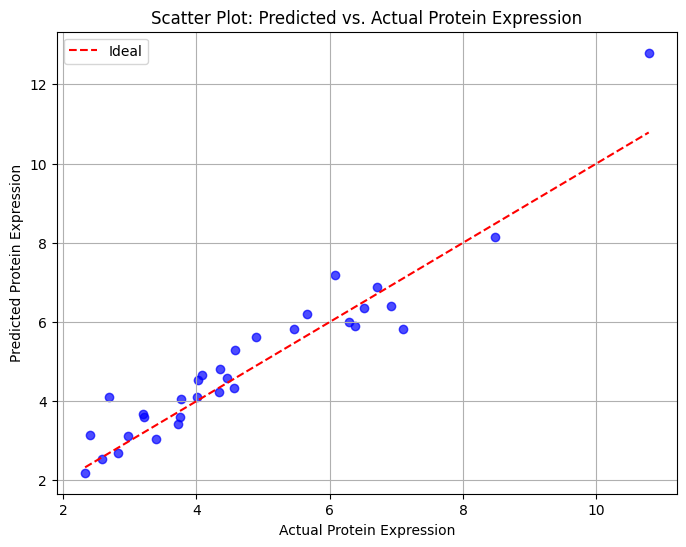

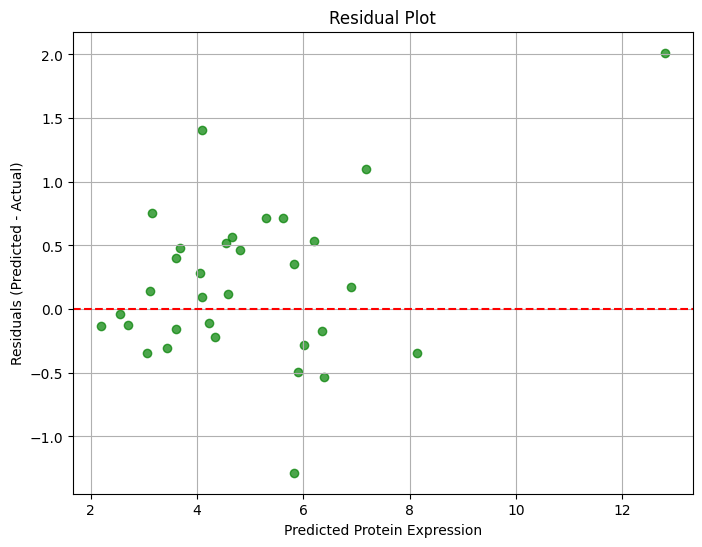

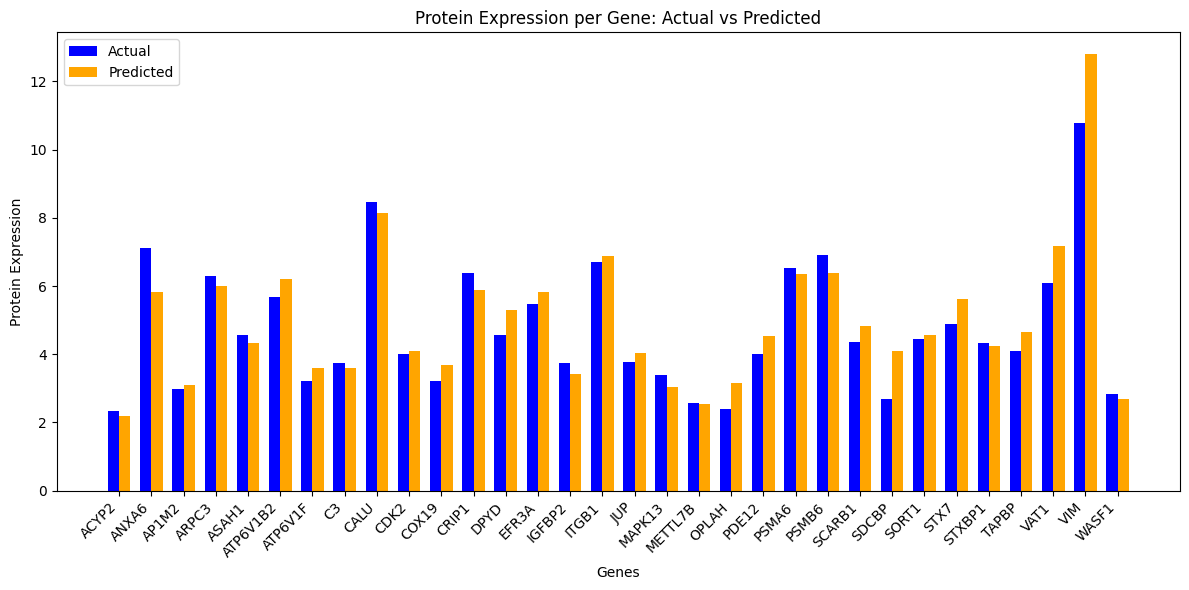

tensor([[ 2.0081,  6.8214, -1.4422,  7.5533,  8.1022,  7.7781,  7.3691,  1.3778,
         10.3751,  8.0586,  4.4931, -2.0028,  2.3387,  6.4589,  4.6659,  9.4875,
          3.9481,  0.7474,  0.5226, -0.4474,  5.8413,  7.1614,  6.1972,  8.0009,
          8.7894,  7.6461,  6.4710,  7.2273,  6.5906,  8.6013, 10.9100,  4.2421]])
(32,) (32,)
Quanitative Results for : ['SIDM01240']
                         Metric    Value
Pearson Correlation Coefficient 0.993611
       Mean Squared Error (MSE) 0.096592
 Root Mean Squared Error (RMSE) 0.310792
      Mean Absolute Error (MAE) 0.257262
                 R-squared (R²) 0.977767


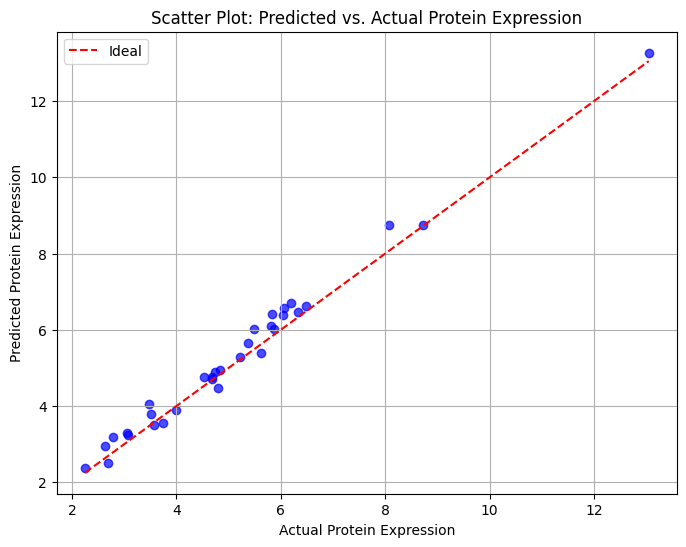

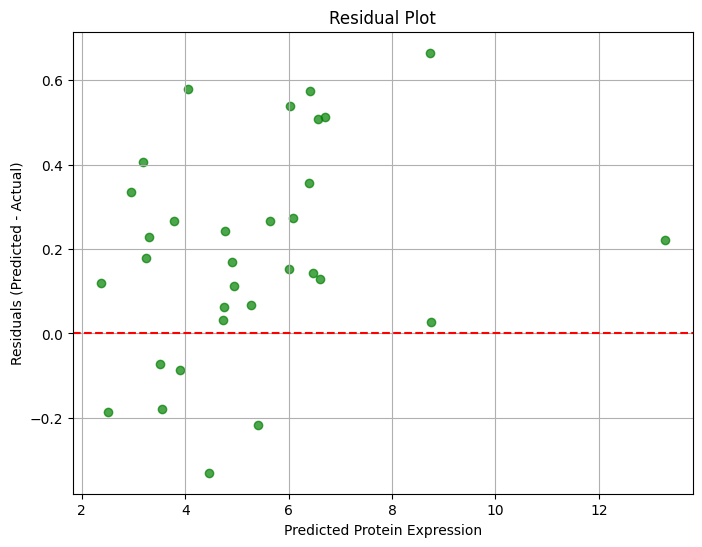

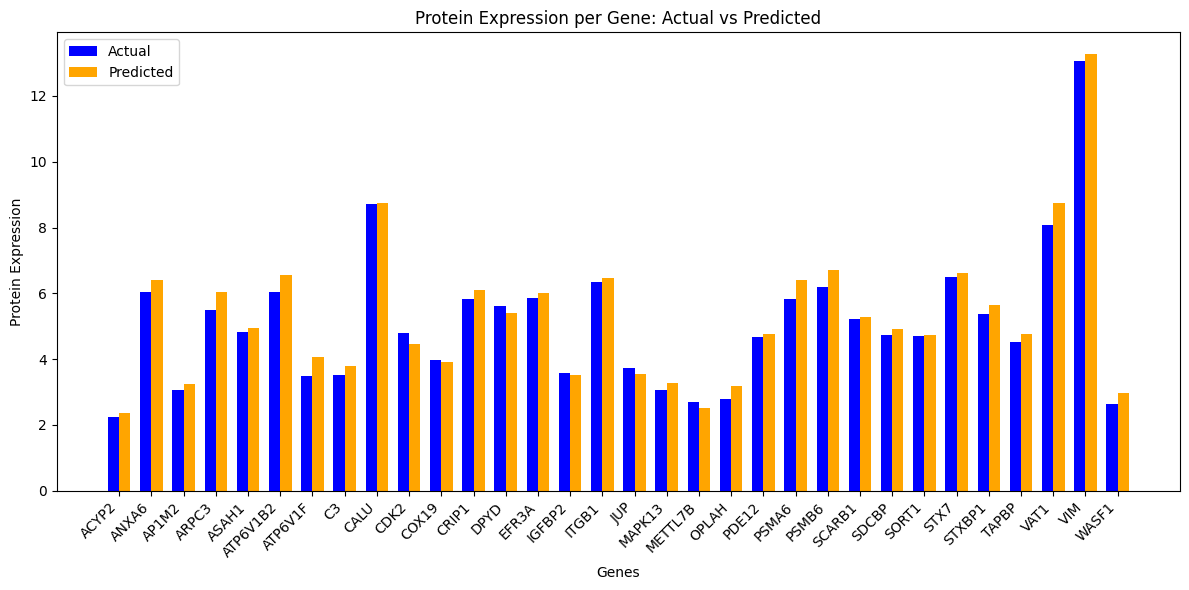

tensor([[ 2.0096,  6.8281, -1.5387,  7.5556,  8.0373,  7.8495,  7.2779,  1.0225,
          9.9535,  8.0744,  4.3834, -2.1285,  2.4165,  6.1733,  4.2998,  9.3688,
          4.0264,  0.8547,  0.3360, -0.0235,  5.9338,  7.1219,  6.3570,  7.9847,
          8.7780,  7.7159,  6.6389,  7.3333,  6.5229,  8.5009, 10.3668,  4.0902]])
(32,) (32,)
Quanitative Results for : ['SIDM01242']
                         Metric    Value
Pearson Correlation Coefficient 0.994621
       Mean Squared Error (MSE) 0.066470
 Root Mean Squared Error (RMSE) 0.257817
      Mean Absolute Error (MAE) 0.201613
                 R-squared (R²) 0.985664


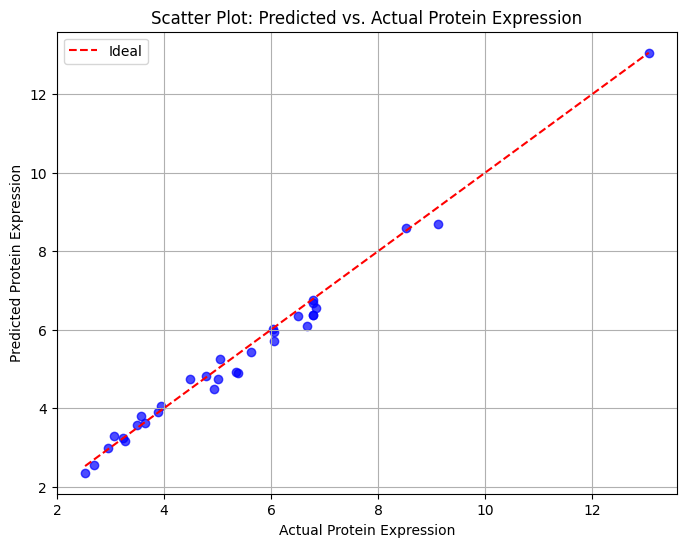

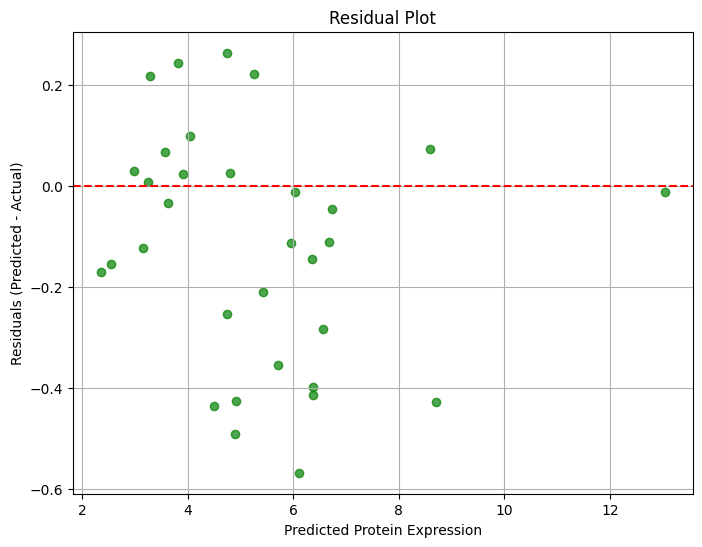

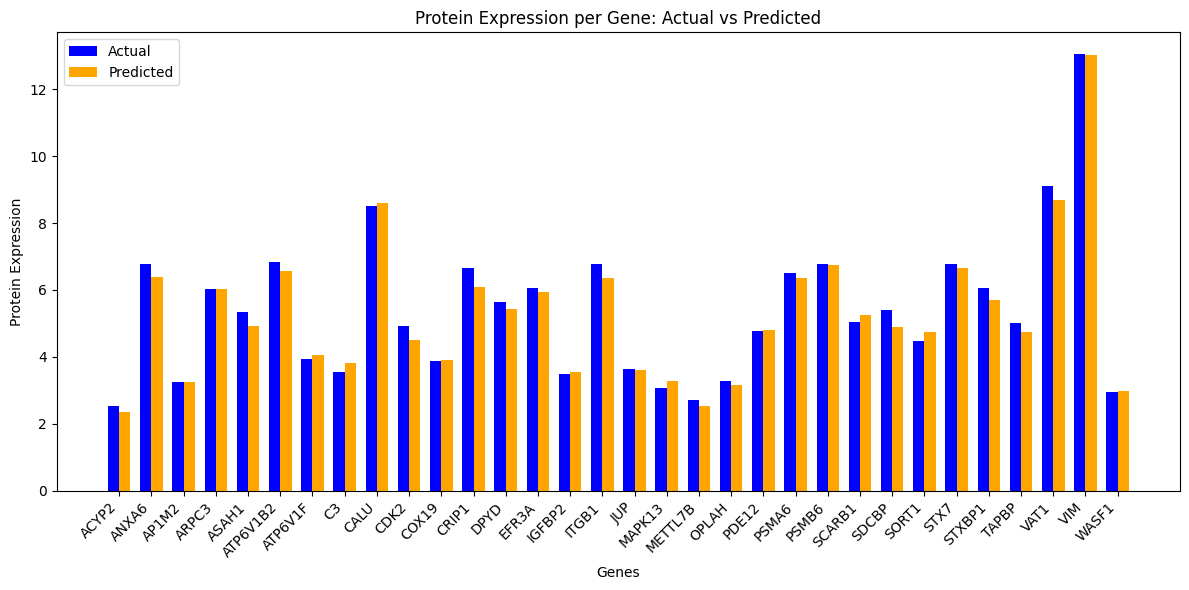

In [8]:
import torch
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # Use deterministic CUDA algorithms
    torch.backends.cudnn.benchmark = False

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# Loading the data
proteomics_df = pd.read_csv('/content/drive/MyDrive/EMBL_Task/Skin/high_low_correlation_proteomics.csv')
transcriptomics_df  = pd.read_csv('/content/drive/MyDrive/EMBL_Task/Skin/high_low_correlation_transcriptomics.csv')

# Identify common genes and filter datasets
protein_names = set(proteomics_df.columns)
common_genes = [gene for gene in transcriptomics_df.columns if gene in protein_names]
filtered_transcriptomics_df = transcriptomics_df[common_genes]

# Find common columns between proteomics and transcriptomics
common_columns = sorted(list(set(proteomics_df.columns).intersection(set(transcriptomics_df.columns))))
filtered_proteomics_df = proteomics_df[common_columns]
filtered_transcriptomics_df = transcriptomics_df[common_columns]
common_names = [col for col in common_columns if col != 'Unnamed: 0']

# Split the data into train and validation sets
train_df_proteomics = filtered_proteomics_df.iloc[:40]
val_df_proteomics = filtered_proteomics_df.iloc[40:]
train_df_transcriptomics = filtered_transcriptomics_df.iloc[:40]
val_df_transcriptomics = filtered_transcriptomics_df.iloc[40:]

# Dataset class
class MultiOmicsDataset(Dataset):
    def __init__(self, proteomics_df, transcriptomics_df):
        self.subject_ids = proteomics_df["Unnamed: 0"].values
        self.proteomics_data = torch.tensor(proteomics_df.drop(columns=['Unnamed: 0']).values, dtype=torch.float32)
        self.transcriptomics_data = torch.tensor(transcriptomics_df.drop(columns=['Unnamed: 0']).values, dtype=torch.float32)

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        return {
            'subject_id': self.subject_ids[idx],
            'proteomics': self.proteomics_data[idx],
            'transcriptomics': self.transcriptomics_data[idx]
        }

# Create DataLoader
train_dataset = MultiOmicsDataset(train_df_proteomics, train_df_transcriptomics)
val_dataset = MultiOmicsDataset(val_df_proteomics, val_df_transcriptomics)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

class TranscriptToProteomicsTransformer(nn.Module):
    def __init__(self, feature_dim=32, d_model=128, nhead=2, num_layers=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.feature_dim = feature_dim
        self.d_model = d_model

        # 1. Linear projection: embed each feature (token) into d_model
        self.input_proj = nn.Linear(1, d_model)

        # 2. Positional encoding: optional but helps capture position
        self.pos_embedding = nn.Parameter(torch.randn(1, feature_dim, d_model))

        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Project back to 1 value per feature
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: [B, feature_dim] → we treat each feature as a token
        Output: [B, feature_dim]
        """
        B, F = x.shape

        # Treat each feature as a token: reshape to [B, F, 1]
        x = x.unsqueeze(-1)

        # Project to transformer space: [B, F, d_model]
        x = self.input_proj(x)

        # Add position encoding
        x = x + self.pos_embedding[:, :F, :]

        # Transformer encoder
        x = self.transformer_encoder(x)  # [B, F, d_model]

        # Back to scalar predictions per feature
        x = self.output_proj(x).squeeze(-1)  # [B, F]
        return x
# Create the model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to calculate all evaluation metrics and return them as a dictionary
def evaluate_metrics(y_true, y_pred):
    """Calculate multiple evaluation metrics and return them as a dictionary."""
    metrics = {}


    y_true = y_true.numpy().flatten()
    y_pred = y_pred.numpy().flatten()

    print(y_true.shape, y_pred.shape)
    # Pearson Correlation Coefficient
    metrics['Pearson Correlation Coefficient'] = np.corrcoef(y_true, y_pred)[0, 1]

    # Mean Squared Error (MSE)
    metrics['Mean Squared Error (MSE)'] = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    metrics['Root Mean Squared Error (RMSE)'] = np.sqrt(metrics['Mean Squared Error (MSE)'])

    # Mean Absolute Error (MAE)
    metrics['Mean Absolute Error (MAE)'] = mean_absolute_error(y_true, y_pred)

    # R-squared (R²)
    metrics['R-squared (R²)'] = r2_score(y_true, y_pred) # r2_score(true_np, pred_np)
    return metrics
def plot_evaluation(true, pred, gene_names=None):
    # Ensure data are numpy arrays
    true = np.asarray(true)
    pred = np.asarray(pred)

    n_samples, n_features = true.shape

    # -- 1. Scatter Plot: Predicted vs Actual for all data points (flatten if multi-sample)
    plt.figure(figsize=(8, 6))
    plt.scatter(true.flatten(), pred.flatten(), alpha=0.7, color='b')
    plt.xlabel('Actual Protein Expression')
    plt.ylabel('Predicted Protein Expression')
    plt.title('Scatter Plot: Predicted vs. Actual Protein Expression')
    plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal')
    plt.legend()
    plt.grid(True)
    plt.show()

    # -- 2. Residual Plot: Residuals (Predicted - Actual) vs. Predicted
    residuals = pred - true
    plt.figure(figsize=(8, 6))
    plt.scatter(pred.flatten(), residuals.flatten(), alpha=0.7, color='g')
    plt.xlabel('Predicted Protein Expression')
    plt.ylabel('Residuals (Predicted - Actual)')
    plt.title('Residual Plot')
    plt.axhline(0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()

    # -- 3. Prediction vs. Actual Expression for Each Gene (Line Plot)
    # For a single sample, just plot a bar chart comparing each gene
    plt.figure(figsize=(12, 6))
    x = np.arange(n_features)
    width = 0.35
    plt.bar(x - width/2, true[0], width, label='Actual', color='blue')
    plt.bar(x + width/2, pred[0], width, label='Predicted', color='orange')
    plt.xlabel('Genes')
    plt.ylabel('Protein Expression')
    plt.title('Protein Expression per Gene: Actual vs Predicted')
    plt.xticks(x, gene_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
def validate_fn(model, val_loader):
    model.eval()
    with torch.no_grad():  # No need to track gradients during validation
        for batch in val_loader:
            x = batch['transcriptomics']  # Input data
            y_true = batch['proteomics']       # Ground truth labels
            ID = batch['subject_id']
            print(x)
            y_pred = model(x)               # Model predictions
            #print(y_pred)
            #print(y_true)
            metrics = evaluate_metrics(y_true, y_pred)
            # Convert the dictionary into a DataFrame for better visualization
            metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
            # Print the results as a table
            print('Quanitative Results for :', ID)
            print(metrics_df.to_string(index=False))
            plot_evaluation(y_true, y_pred, gene_names=common_names)


path_to_checkpoints = '/content/drive/MyDrive/EMBL_Task/Skin/High_Low_Correlation_Model.pth.tar'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def eval_():
        model = TranscriptToProteomicsTransformer().to(device=DEVICE,dtype=torch.float)
        checkpoint = torch.load(path_to_checkpoints,map_location=DEVICE)
        model.load_state_dict(checkpoint['state_dict'])
        validate_fn(model, val_loader)


if __name__ == "__main__":
    eval_()
